## Import Packages

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Slice dataset into smaller chunks for EDA

In [3]:
# sell_prices.csv
price = pd.read_csv('../data/sell_prices.csv')
price_CA1 = price[price['store_id']=='CA_1']
price_CA2 = price[price['store_id']=='CA_2']
price_CA3 = price[price['store_id']=='CA_3']
price_CA1.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [4]:
# calendar.csv
calendar = pd.read_csv('../data/calendar.csv')
calendar_train = calendar[:1913]
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [5]:
# sales_train_validation.csv
sale = pd.read_csv('../data/sales_train_validation.csv')
sale_CA1 = sale[sale['store_id'] == 'CA_1']
sale_CA1.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


### Analysis on events during training period (d_1 ~ d_1913)

In [6]:
event1 = calendar_train[['event_name_1','event_type_1']].dropna()
event2 = calendar_train[['event_name_2','event_type_2']].dropna()
ttl_event = pd.concat([event1.rename(columns = {'event_name_1':'event_name','event_type_1':'event_type'}), 
                       event2.rename(columns = {'event_name_2':'event_name','event_type_2':'event_type'})])
print("There are", event1['event_name_1'].nunique(), "unique event_1,", event2['event_name_2'].nunique(), 
      "unique event_2, and",  ttl_event['event_name'].nunique(), "total unique event in the training period.")
print("There are", event1.shape[0], "days have event_1, and", event2.shape[0], 
      "days have event2 while", calendar_train.shape[0]-event1.shape[0], "days do not have any event.")
ttl_event.groupby('event_type').size()

There are 30 unique event_1, 4 unique event_2, and 30 total unique event in the training period.
There are 154 days have event_1, and 4 days have event2 while 1759 days do not have any event.


event_type
Cultural     38
National     51
Religious    53
Sporting     16
dtype: int64

### Analysis on SNAP purchases

* Find how many days which SNAP purchases are allowed in the three states

In [7]:
print("There are totally", sum(calendar['snap_CA']==1), "days where SNAP purchases are allowed in CA.")
print("There are totally", sum(calendar['snap_TX']==1), "days where SNAP purchases are allowed in TX.")
print("There are totally", sum(calendar['snap_WI']==1), "days where SNAP purchases are allowed in WI.")

There are totally 650 days where SNAP purchases are allowed in CA.
There are totally 650 days where SNAP purchases are allowed in TX.
There are totally 650 days where SNAP purchases are allowed in WI.


* Find the dates on which SNAP purchases are allowed in the three states

In [8]:
# CA
snap_date_CA = calendar[calendar['snap_CA']==1]['date'].str[-2:]
snap_date_CA.value_counts().sort_index()

01    65
02    65
03    65
04    65
05    65
06    65
07    65
08    65
09    65
10    65
Name: date, dtype: int64

In [9]:
# TX
snap_date_TX = calendar[calendar['snap_TX']==1]['date'].str[-2:]
snap_date_TX.value_counts().sort_index()

01    65
03    65
05    65
06    65
07    65
09    65
11    65
12    65
13    65
15    65
Name: date, dtype: int64

In [10]:
# WI
snap_date_WI = calendar[calendar['snap_WI']==1]['date'].str[-2:]
snap_date_WI.value_counts().sort_index()

02    65
03    65
05    65
06    65
08    65
09    65
11    65
12    65
14    65
15    65
Name: date, dtype: int64

### Analysis on prices

In [ ]:
# Find missing values in price
# Find the weeks that the weekly avg. price is missing for each item in the CA1 store
price_missing = {}
unq_wm_wk = set(calendar['wm_yr_wk'].unique())
for item in price_CA1['item_id'].unique():
    missing_wk = list(unq_wm_wk - set(price_CA1[price_CA1['item_id']==item]['wm_yr_wk'].unique()))
    if len(missing_wk)>0:
        price_missing[item] = missing_wk
        
# Replace missing weekly avg. prices with the prices of the same item for the same week in other stores
replace_price = pd.Dataframe(columns = ['item_id', 'sell_price'])
replace_price.append('AB')
for k in price_missing.keys():
    for v in price_missing[k]:
        if price_CA2[(price_CA2['item_id']==k) & (price_CA2['w']==v)]['sell_price'].empty:

### Create dataset for prediction

In [11]:
# Transpose 'd_1' to 'd_1913' columns of 'sale'
sale_colname = sale.columns
sale_CA1 = pd.melt(sale[sale['store_id'] == 'CA_1'], id_vars=sale_colname[1:6],
                   value_vars=sale_colname[6:], var_name='d', value_name='sales')
sale_CA1.head()

,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [25]:
# Merge 'sale_CA1' with 'calendar' & 'price_CA1'
CA1 = pd.merge(sale_CA1, calendar, how='left', on='d')
CA1_all = pd.merge(CA1, price_CA1, how='left')
CA1_all.head()

,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


In [40]:
df_CA1 = CA1_all[['item_id','dept_id','cat_id','d','sales','wm_yr_wk','event_name_1',
                 'event_type_1','event_name_2','event_type_2','snap_CA']].copy()
df_CA1['d_new'] = df_CA1['d'].str[2:].astype('int')
df_CA1['week'] = df_CA1['wm_yr_wk']-11100
df_CA1 = df_CA1.sort_values(['item_id', 'd_new']).reset_index(drop=True)
df_CA1.head()

,item_id,dept_id,cat_id,d,sales,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,d_new,week
0,FOODS_1_001,FOODS_1,FOODS,d_1,3,11101,NaN,NaN,NaN,NaN,0,1,1
1,FOODS_1_001,FOODS_1,FOODS,d_2,0,11101,NaN,NaN,NaN,NaN,0,2,1
2,FOODS_1_001,FOODS_1,FOODS,d_3,0,11101,NaN,NaN,NaN,NaN,0,3,1
3,FOODS_1_001,FOODS_1,FOODS,d_4,1,11101,NaN,NaN,NaN,NaN,1,4,1
4,FOODS_1_001,FOODS_1,FOODS,d_5,4,11101,NaN,NaN,NaN,NaN,1,5,1


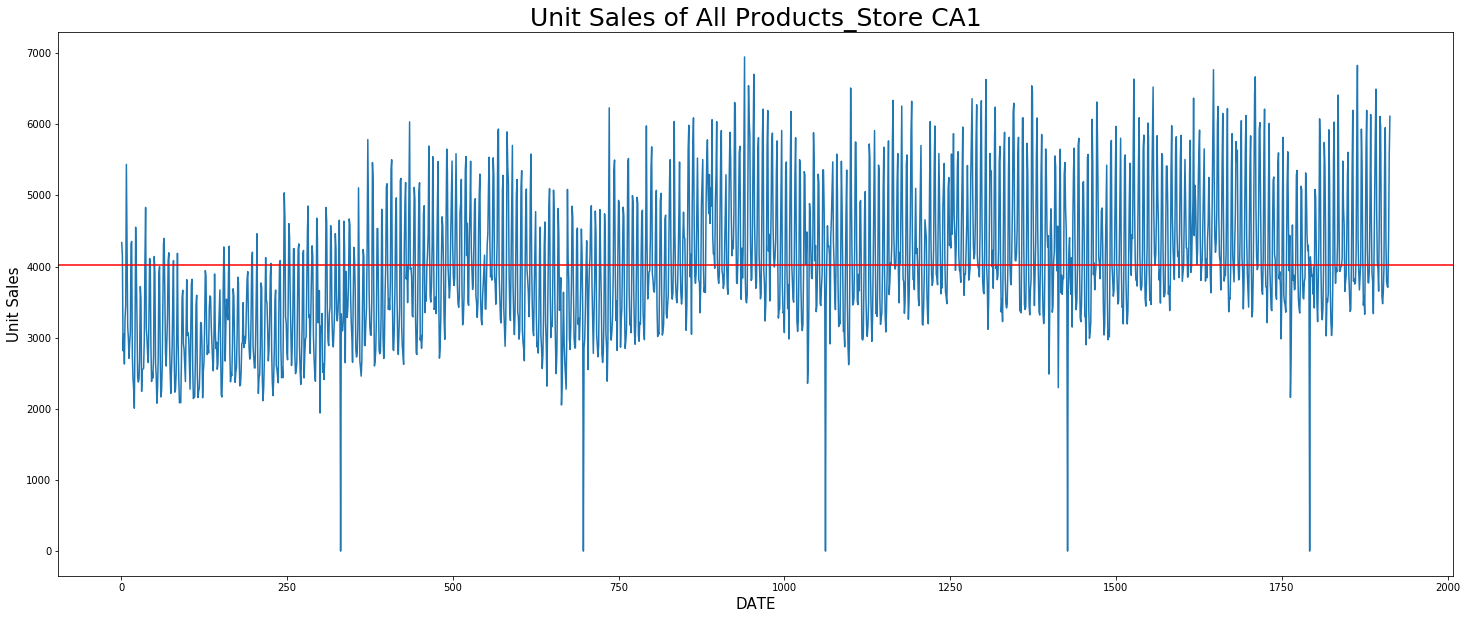

In [109]:
plt.figure(figsize=(25,10))
sales_all_item = df_CA1.groupby('d_new')['sales'].sum().reset_index()
avg_sales = sales_all_item['sales'].mean()
plt.plot('d_new', 'sales', data=sales_all_item)
plt.axhline(avg_sales, color='red')
plt.xlabel('DATE', fontsize=15)
plt.ylabel('Unit Sales', fontsize=15)
plt.title('Unit Sales of All Products_Store CA1', fontsize=25)
plt.show()

* Reference of LSTM Model:
#### (1) https://towardsdatascience.com/predicting-sales-611cb5a252de
#### (2) https://medium.com/@daniel820710/%E5%88%A9%E7%94%A8keras%E5%BB%BA%E6%A7%8Blstm%E6%A8%A1%E5%9E%8B-%E4%BB%A5stock-prediction-%E7%82%BA%E4%BE%8B-1-67456e0a0b

In [111]:
#create a new dataframe to model the difference
CA1_sale_diff = sales_all_item.copy()

#add previous sales to the next row
CA1_sale_diff['prev_sales'] = CA1_sale_diff['sales'].shift(1)

#drop the null values and calculate the difference
CA1_sale_diff = CA1_sale_diff.dropna()
CA1_sale_diff['diff'] = CA1_sale_diff['sales'] - CA1_sale_diff['prev_sales']
CA1_sale_diff.head()

,d_new,sales,prev_sales,diff
1,2,4155,4337.0,-182.0
2,3,2816,4155.0,-1339.0
3,4,3051,2816.0,235.0
4,5,2630,3051.0,-421.0
5,6,3276,2630.0,646.0


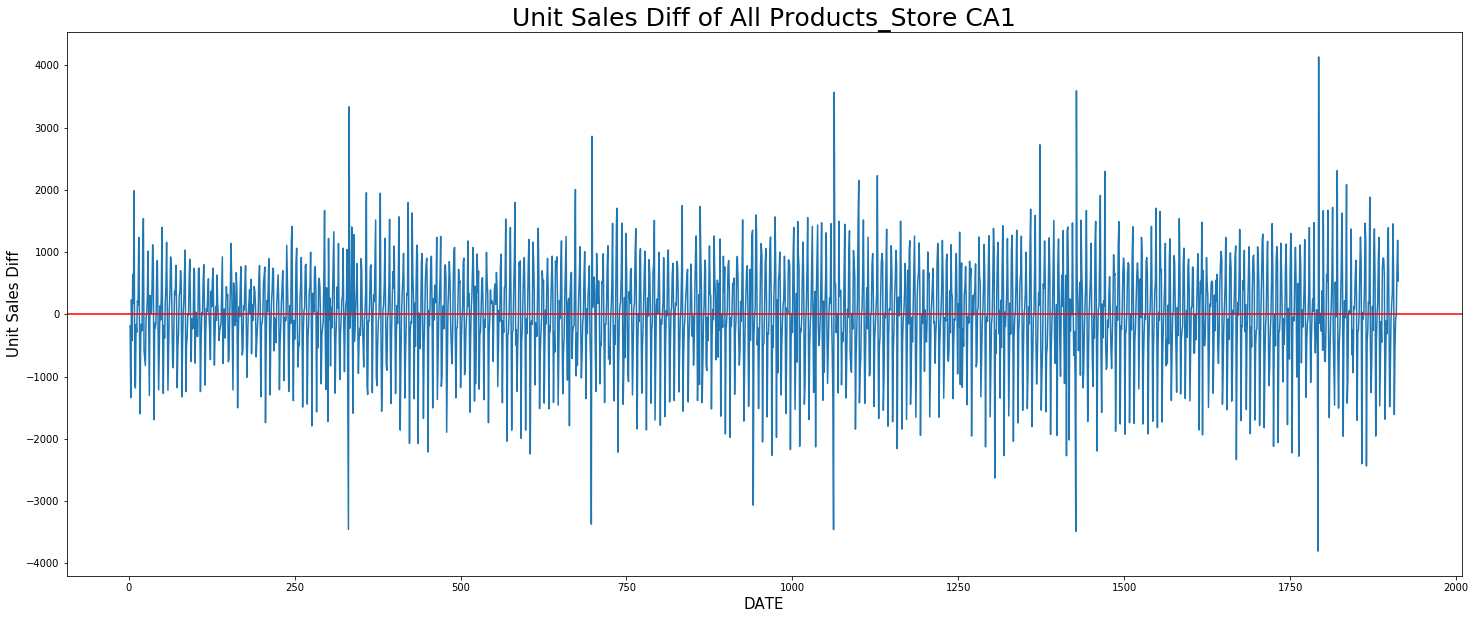

In [113]:
plt.figure(figsize=(25,10))
plt.plot('d_new', 'diff', data=CA1_sale_diff)
avg_sales_diff = CA1_sale_diff['diff'].mean()
plt.axhline(avg_sales_diff, color='red')
plt.xlabel('DATE', fontsize=15)
plt.ylabel('Unit Sales Diff', fontsize=15)
plt.title('Unit Sales Diff of All Products_Store CA1', fontsize=25)
plt.show()

In [118]:
#create dataframe for transformation from time series to supervised
df_supervised = CA1_sale_diff.drop(['prev_sales'],axis=1)

#adding lags
for inc in range(1,31):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)

#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)
df_supervised.head()

,d_new,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
0,32,2549,303.0,-1302.0,-171.0,1018.0,287.0,37.0,-64.0,-823.0,...,-162.0,-1183.0,-1097.0,1987.0,174.0,646.0,-421.0,235.0,-1339.0,-182.0
1,33,2559,10.0,303.0,-1302.0,-171.0,1018.0,287.0,37.0,-64.0,...,-285.0,-162.0,-1183.0,-1097.0,1987.0,174.0,646.0,-421.0,235.0,-1339.0
2,34,2568,9.0,10.0,303.0,-1302.0,-171.0,1018.0,287.0,37.0,...,218.0,-285.0,-162.0,-1183.0,-1097.0,1987.0,174.0,646.0,-421.0,235.0
3,35,2978,410.0,9.0,10.0,303.0,-1302.0,-171.0,1018.0,287.0,...,150.0,218.0,-285.0,-162.0,-1183.0,-1097.0,1987.0,174.0,646.0,-421.0
4,36,4096,1118.0,410.0,9.0,10.0,303.0,-1302.0,-171.0,1018.0,...,1238.0,150.0,218.0,-285.0,-162.0,-1183.0,-1097.0,1987.0,174.0,646.0
